In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [41]:
df = pd.read_csv('../../data/train_cleanV4.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [42]:
#Removing NaN values
df['user_mentions'] = df['user_mentions'].fillna(value='-')
df['urls'] = df['urls'].fillna(value='-')
df['hashtags'] = df['hashtags'].fillna(value='-')

In [43]:
def number_elements(x):
    if x != '-':
        return len(x.split(' '))
    else:
        return 0

In [44]:
df['nbr_user_mentions'] = pd.DataFrame(df['user_mentions'].apply(lambda x: number_elements(x)))
df['nbr_hashtags'] = pd.DataFrame(df['hashtags'].apply(lambda x: number_elements(x)))
df['nbr_urls'] = pd.DataFrame(df['urls'].apply(lambda x: number_elements(x)))

In [45]:
df.head(3)

,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text,nbr_user_mentions,nbr_hashtags,nbr_urls,retweet_sup_20,timestamp,hour,date,text_len
0,0,0,0.009504,9.405109e-06,0.000279,-,-,-,smh give,0,0,0,1,2020-05-05 16:42:35,16,1,13
1,0,0,0.000043,4.356590e-07,0.000046,-,-,-,us human be think miss boat georg,0,0,0,1,2020-05-03 00:15:48,0,6,69
2,0,0,0.000450,1.430841e-05,0.000529,-,-,-,old dirti trick trump like know fauci would sa...,0,0,0,1,2020-05-04 23:24:33,23,0,99


#### Random forest classification

We will try to make a simple classification. We will try to predict if a retweet will have more than 20 retweets.

- 0 : [0,4] retweets
- 1 : [4,196] retweets
- 2 : [197, inf[ retweets

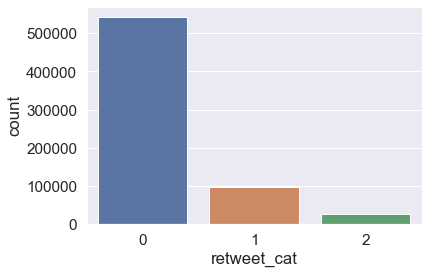

In [163]:
sup_5 = df['retweet_count'] > 5
sup_196 = df['retweet_count'] > 196 
df['retweet_cat'] = sup_5.astype(int) + sup_196.astype(int)
sns.countplot(x= 'retweet_cat', data=df)

We see that we globally have much more tweets with less than 20 retweets. We will consider the retweets higher than 20 as outliers.

Let's try to balance the class before applying the RandomForest algorithm.

In [47]:
g = df.groupby('retweet_sup_4')
df_balanced = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

In [48]:
X = df_balanced[['user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'nbr_user_mentions', 'nbr_hashtags', 'nbr_urls', 'hour', 'date', 'text_len']].reset_index()
X = X.drop(['retweet_sup_20', 'level_1'], axis=1)
y = df_balanced['retweet_sup_20']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [50]:
clf=RandomForestClassifier(n_estimators=100)
#clf.fit(X_train,y_train)

In [51]:
#predictions
y_pred=clf.predict(X_test)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

In [ ]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))

It's not perfect but we are roughly able to predict which tweet is going to be an outlier and which on will not. Let's try a prediction on the entire dataset.

#### Now, let's apply our trained Random Forest algorithm to predit the class if tweets will have more or less than 20 retweets on the evaluation dataset.

In [77]:
eval_data = pd.read_csv("../../data/eval_clean_final.csv")

In [78]:
X_val = eval_data[['user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'nbr_user_mentions', 'nbr_hashtags', 'nbr_urls', 'hour', 'date', 'text_len']]

In [79]:
y_pred=clf.predict(X_val)
eval_data['retweet_sup_20'] = y_pred

In [80]:
X_val.head()

,user_verified,user_statuses_count,user_followers_count,user_friends_count,nbr_user_mentions,nbr_hashtags,nbr_urls,hour,date,text_len
0,0,0.000032,3.075185e-07,0.000066,1,1,0,2,1,93
1,1,0.014862,3.525614e-04,0.000218,1,1,0,23,5,19
2,0,0.003352,2.947053e-06,0.000134,1,1,0,3,0,124
3,1,0.000107,5.599400e-05,0.000056,1,1,3,0,1,297
4,0,0.004528,5.543876e-05,0.000807,1,1,2,15,1,69


In [81]:
# too much values for '0'
eval_data.retweet_sup_20.value_counts()

1    262458
0     22876
Name: retweet_sup_20, dtype: int64

In [82]:
eval_data.to_csv('../../data/eval_clean_final_pred20.csv')

In [83]:
eval_data.head()

,id,timestamp,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text,text_len,nbr_user_mentions,nbr_hashtags,nbr_urls,hour,date,retweet_sup_20
0,665776,2020-05-05 02:08:09,0,0.000032,3.075185e-07,0.000066,NaN,-,NaN,coronaviru spring break chri brown fan page fo...,93,1,1,0,2,1,1
1,665777,2020-05-02 23:59:48,1,0.014862,3.525614e-04,0.000218,NaN,-,NaN,fit data,19,1,1,0,23,5,1
2,665778,2020-05-04 03:45:32,0,0.003352,2.947053e-06,0.000134,NaN,-,NaN,yall talk coronaviru like yall studi 10 plu ye...,124,1,1,0,3,0,1
3,665779,2020-05-05 00:40:10,1,0.000107,5.599400e-05,0.000056,NaN,"twitter.com/i/web/status/1…, https://t.co/F5Ld...",NaN,coronaviru covid-19 go food secur crisi mani i...,297,1,1,3,0,1,1
4,665780,2020-05-05 15:34:27,0,0.004528,5.543876e-05,0.000807,NaN,"vice.com/en_us/article/…, https://t.co/WRiT4p4eaU",NaN,big brother good watch,69,1,1,2,15,1,1


## Let's train the RandomForest on the original unbalanced dataset.

In [70]:
df_samp = df.sample(n=100000)

X = df[['user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'nbr_user_mentions', 'nbr_hashtags', 'nbr_urls', 'hour', 'date', 'text_len']].reset_index()
X = X.drop(['index'], axis=1)
y = df['retweet_sup_20']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [72]:
clf=RandomForestClassifier(n_estimators=50)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [73]:
#predictions
y_pred=clf.predict(X_test)

In [74]:
pd.Series(y_pred).value_counts()

1    182549
0     17185
dtype: int64

In [75]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

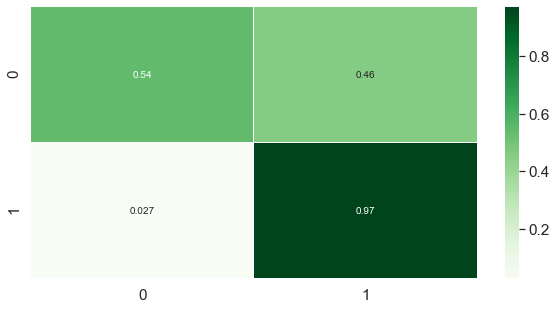

In [76]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

In [59]:
print('Parameters currently in use:\n')
display(clf.get_params())

Parameters currently in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Random forest tuning

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
display(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train)

## PCA on X_val for reducing dimensions

In [102]:
X.drop(columns=['date', 'hour'], inplace=True) 
X.text_len = X.text_len / X.text_len.max()
X.nbr_user_mentions = X.nbr_user_mentions / X.nbr_user_mentions.max()
X.nbr_hashtags = X.nbr_hashtags / X.nbr_hashtags.max()
X.nbr_urls = X.nbr_urls / X.nbr_urls.max()
X.head(3)

,user_statuses_count,user_followers_count,user_friends_count,nbr_user_mentions,nbr_hashtags,nbr_urls,text_len
0,0.009504,9.405109e-06,0.000279,0.0,0.0,0.0,0.013171
1,0.000043,4.356590e-07,0.000046,0.0,0.0,0.0,0.069909
2,0.000450,1.430841e-05,0.000529,0.0,0.0,0.0,0.100304


In [103]:
from sklearn.decomposition import PCA

In [107]:
pca = PCA(n_components=7)

In [108]:
pca.fit(X)

PCA(n_components=7)

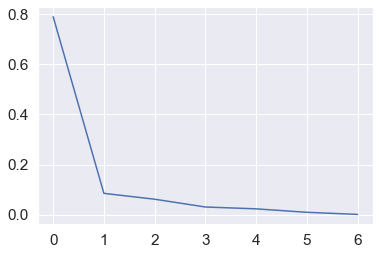

In [109]:
plt.plot(pca.explained_variance_ratio_)

In [110]:
pca.explained_variance_ratio_

array([0.79014406, 0.08488016, 0.06149133, 0.0304106 , 0.02302822,
       0.00925417, 0.00079146])

In [114]:
X_pca = pca.transform(X)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3) # 70% training and 30% test

In [118]:
clf=RandomForestClassifier(n_estimators=50)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [119]:
#predictions
y_pred=clf.predict(X_test)

In [120]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

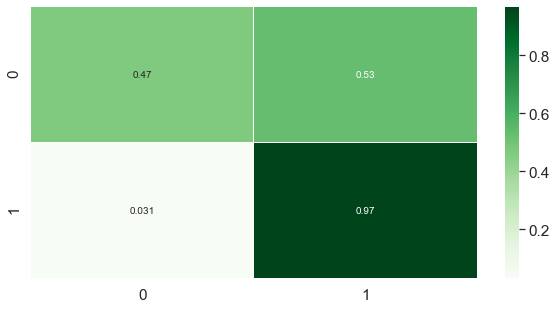

In [121]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

In [129]:
len(df.retweet_count)

665777

In [132]:
df.retweet_count.sort_values().iloc[532622]

4

In [154]:
A = df.retweet_count.sort_values()
A.to_numpy()[639145]

196

In [165]:
df[df['retweet_count'] < 4].retweet_count.value_counts().sum()

521989

In [167]:
df.drop(columns=['retweet_sup_4'], inplace=True)

In [168]:
df.to_csv('../../data/train_cleanV4.csv')